# Introduction

Image persistence in the IR array occurs whenever a pixel is exposed to light that exceeds more than about half of the full well of a pixel in the array. Persistence can occur within a single visit, as the different exposures in a visit are dithered. Persistence also occurs from observations in a previous visit of completely different fields.

Image persistence is seen in a small, but non-negligible fraction of WFC3/IR exposures. Its properties are discussed in the WFC3 Instrument Handbook in [Chapter 8](http://www.stsci.edu/hst/wfc3/documents/handbooks/currentDHB/Chapter8_persistence1.html). Persistence is primarily a function of the degree to which a pixel is filled (in electrons) and the time since this occurred. Additional information is available from the [WFC3 Persistence Webpage](http://www.stsci.edu/hst/wfc3/ins_performance/persistence/)

This notebook shows how to use persistence products to update the data quality (DQ) array of the IR calibrated FLT dataset for use with AstroDrizzle. When the data is sufficiently dithered, affected regions of the detector may be replaced with 'good' pixels from other exposures in the visit.

The notebook is organized as follows:

        Download the data from MAST 
        Download the persistence data products
        Define a lower threshold in the persistence model for defining a mask (eg. >0.005 e/s)
        For affected pixels, add flag 16384 to the DQ array values
        Redrizzle the FLT data to produce a cleaned DRZ product

# Setup

This notebook assumes you have installed a recent version of AstroConda .

Two additional astropy packages must be installed in your conda environment before downloading the data. To do this, type the following command in the terminal before starting the notebook:

    conda install -c astropy astroquery ccdproc


In [42]:
from ccdproc import ImageFileCollection
from astroquery.mast import Observations
from astropy.io import fits

import matplotlib.pyplot as plt
import numpy as np
import os 
import glob 
import shutil


# Data

Here we obtain WFC3/IR observations from GLASS program 13459, Visit 29 in the F140W filter. These exposures were impacted by persistence from grism exposures obtained just prior to these exposures. 

The following commands query MAST and then downloads the FLT and DRZ data products to the current directory.

In [4]:
data_list = Observations.query_criteria(obs_id='ica529*',filters='F140W')

Observations.download_products(data_list['obsid'],mrp_only=False,download_dir='./data',
                               productSubGroupDescription=['FLT','DRZ'])

science_files = glob.glob('data/mastDownload/HST/*/*fits')

for im in science_files:
    root = im.split('/')[-1]
    os.rename(im,'./'+root)
shutil.rmtree('data/')

# Obtain the Persistence Model Products 

To find the URL of the tar file containing the persistence fits files, visit the [PERSIST Search Form](https://archive.stsci.edu/prepds/persist/search.php) and search for dataset='ica529*'.

Hover over the link in the Visit colum to get the URL to the gzipped tar file for Visit 29. 
The persistence model data products we will use to create a mask are named 'rootname_persist.fits' and contain contributions from both external and internal persistence. 

We define external persistence as residual signal that is generated by an earlier visit, and internal persistence as that generated within the same visit as the image in question. External persistence typically comes from a prior scheduled WFC3/IR program and is not within the control of the observer. Internal persistence can be mitigated by the observer by dithering the exposures within a given visit. 

In [ ]:
import urllib
request=urllib.request.urlopen('https://archive.stsci.edu/pub/wfc3_persist/13459/Visit29/13459.Visit29.tar.gz')

tar=request.read()
with open('13459.Visit29.tar.gz', "wb") as gzfile:
    gzfile.write(tar)

!tar -zxvf 13459.Visit29.tar.gz


# Observation Summary

Visit 29 contains 4 consecutive dithered exposures in the F140W filter which are obtained in a single orbit. 


In [6]:
collec = ImageFileCollection('./',
                             keywords=["asn_id","targname","filter","samp_seq","nsamp","exptime",
                             "postarg1","postarg2","date-obs","time-obs",], glob_include="ica529*flt.fits", ext=0)
out_table = collec.summary
out_table

file,asn_id,targname,filter,samp_seq,nsamp,exptime,postarg1,postarg2,date-obs,time-obs
str18,str9,str15,str5,str7,int64,float64,float64,float64,str10,str8
ica529rmq_flt.fits,ICA529030,MACS0717.5+3745,F140W,SPARS50,5,152.933533,0.0,0.0,2014-02-19,11:26:12
ica529rsq_flt.fits,ICA529030,MACS0717.5+3745,F140W,SPARS50,6,202.933945,1.355,0.424,2014-02-19,11:47:06
ica529s0q_flt.fits,ICA529030,MACS0717.5+3745,F140W,SPARS50,5,152.933533,0.881,1.212,2014-02-19,12:55:38
ica529s6q_flt.fits,ICA529030,MACS0717.5+3745,F140W,SPARS50,6,202.933945,-0.474,0.788,2014-02-19,13:16:32



# Display the Images

The DRZ product combines the 4 individual FLT exposures and shows faint residual persistence from grism observations obtained just prior to these data.  An example of the 'Persistence Removal Evaluation' for the first dataset ica529rmq may be found [here](https://archive.stsci.edu/pub/wfc3_persist/13459/Visit29/ica529rmq_persist.html).

The DRZ pipeline product is shown on the left, and we can see that the persistence was partiallym, but not completely, removed by the cosmic-ray rejection functionality in AstroDrizzle. The persistence model for the first FLT dataset is shown on the right.  A red box is overplotted on each image to highlight a portion of the detector which is impacted by the grism signal. 


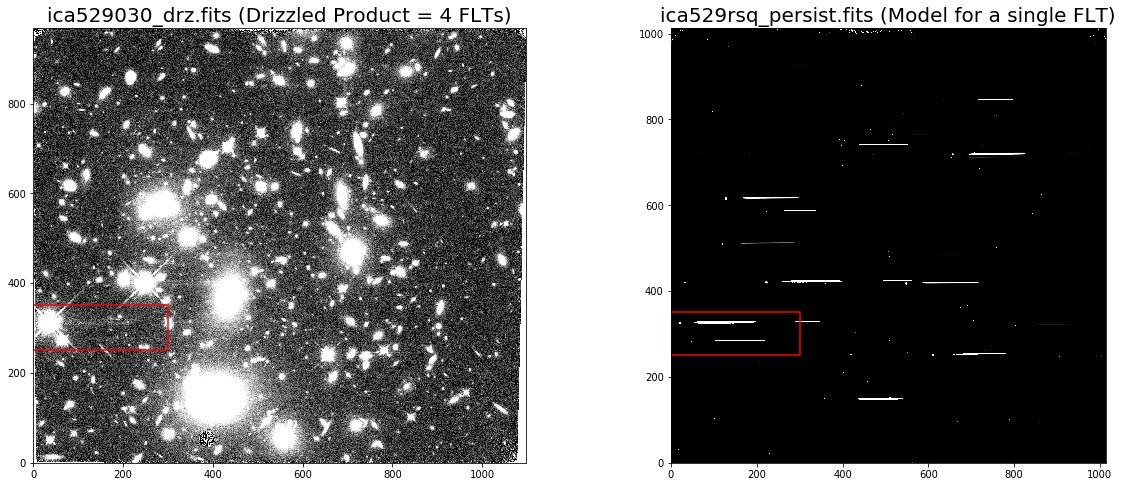

In [38]:
flt1=fits.getdata('ica529rsq_flt.fits',ext=1)
per1=fits.getdata('13459.Visit29/ica529rsq_persist.fits',ext=1)
drz =fits.getdata('ica529030_drz.fits',ext=1)

fig=plt.figure(figsize=(20,8))
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)

ax1.imshow(drz,  vmin=-0.1,vmax=0.35,cmap='Greys_r',origin='lower')
ax2.imshow(per1, vmin=0.0,vmax=0.005,cmap='Greys_r',origin='lower')

ax1.set_title('ica529030_drz.fits (Drizzled Product = 4 FLTs)',fontsize=20)
ax2.set_title('ica529rsq_persist.fits (Model for a single FLT)',fontsize=20)

ax1.plot([0,300,300,0,0],[250,250,350,350,250],c='red')
ax2.plot([0,300,300,0,0],[250,250,350,350,250],c='red')

# Use the persistence model to add DQ flags to each FLT

For any pixels in the model which have a signal greater than 0.005 electrons/sec, we add a flag of 16384 to the current DQ array values in each FLT frame. This threshold is flexible should be determined empirically by the user based on their specific data.


In [12]:
flt1_dq=fits.open('ica529rmq_flt.fits',mode='update')
per1   =fits.getdata('13459.Visit29/ica529rmq_persist.fits',ext=1)

flt2_dq=fits.open('ica529rsq_flt.fits',mode='update')
per2   =fits.getdata('13459.Visit29/ica529rsq_persist.fits',ext=1)

flt3_dq=fits.open('ica529s0q_flt.fits',mode='update')
per3   =fits.getdata('13459.Visit29/ica529s0q_persist.fits',ext=1)

flt4_dq=fits.open('ica529s6q_flt.fits',mode='update')
per4   =fits.getdata('13459.Visit29/ica529s6q_persist.fits',ext=1)

flt1_dq[3].data[per1 > 0.005] += 16384
flt2_dq[3].data[per2 > 0.005] += 16384
flt3_dq[3].data[per3 > 0.005] += 16384
flt4_dq[3].data[per4 > 0.005] += 16384

flt1_dq.close()
flt2_dq.close()
flt3_dq.close()
flt4_dq.close()

# Redrizzle the FLT data with the new DQ flags

Now, we recombine the FLT data with AstroDrizzle using the updated DQ arrays and compare with the pipeline data products.

In [ ]:
from drizzlepac import astrodrizzle
astrodrizzle.AstroDrizzle('ica529*flt.fits',output='ica529030_pcorr',preserve=False,final_bits=576,build=True)

# Display the Original and the Corrected DRZ files

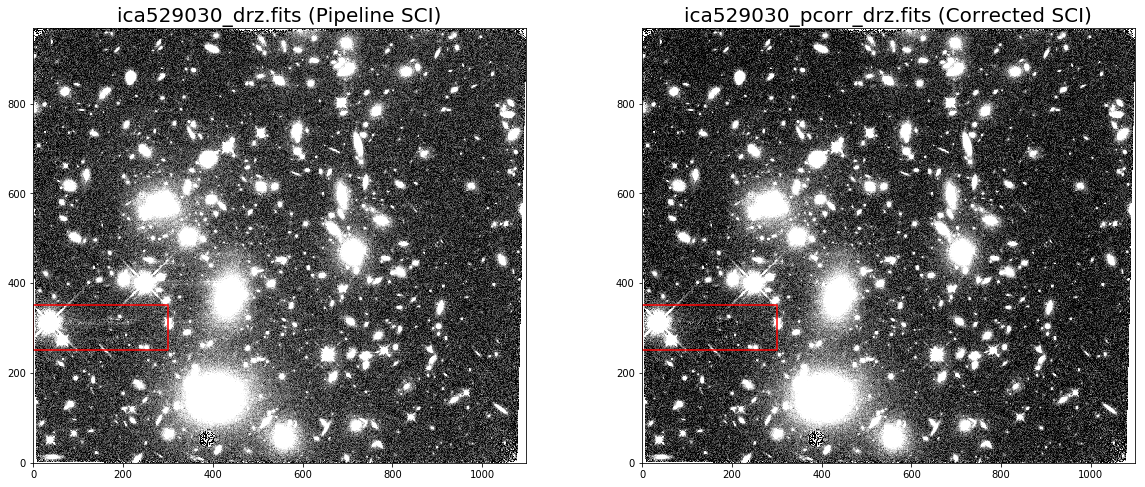

In [39]:
drz      =fits.getdata('ica529030_drz.fits',ext=1)
drz_corr =fits.getdata('ica529030_pcorr_drz.fits',ext=1)

fig=plt.figure(figsize=(20,8))
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)

ax1.imshow(drz,     vmin=-0.1,vmax=0.35,cmap='Greys_r',origin='lower')
ax2.imshow(drz_corr,vmin=-0.1,vmax=0.35,cmap='Greys_r',origin='lower')

ax1.set_title('ica529030_drz.fits (Pipeline SCI)',fontsize=20)
ax2.set_title('ica529030_pcorr_drz.fits (Corrected SCI)',fontsize=20)

ax1.plot([0,300,300,0,0],[250,250,350,350,250],c='red')
ax2.plot([0,300,300,0,0],[250,250,350,350,250],c='red')

# Display the Original and the Corrected WHT files

When final_wht_type='EXP', the drizzled WHT images provide an effective exposure time map of the combined array. 

In the plots below, we can see that the pipeline products have lower weight in the region impacted by the grism, but that only a single frame was flagged and rejected by the cosmic ray algorithm. The grey horizontal bars have a weight ~500 seconds compared to the total exposure ~700 seconds.

In the redrizzled 'Corrected' WHT image, only a single exposure contributed to the darkest horizontal bars which have a value of ~200 seconds. The adjacent grey bars have a weight ~500 seconds and the rest of the WHT image is ~700 seconds. Users will need to experiment with the persistence masking thresholds and consider the size of the dithers in their individual datasets to best combine t

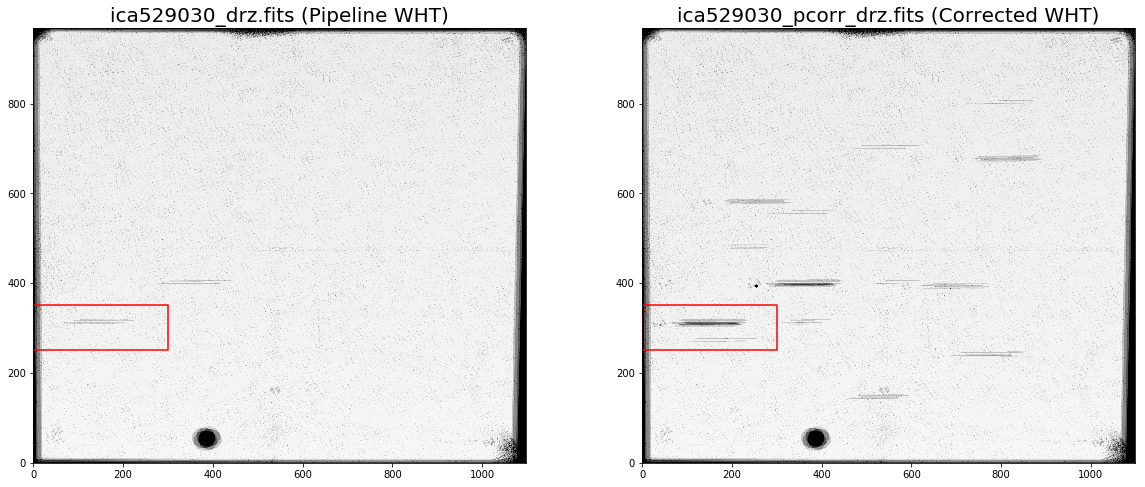

In [40]:
wht      =fits.getdata('ica529030_drz.fits',ext=2)
wht_corr =fits.getdata('ica529030_pcorr_drz.fits',ext=2)

fig=plt.figure(figsize=(20,8))
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)

ax1.imshow(wht,     vmin=0,vmax=800,cmap='Greys_r',origin='lower')
ax2.imshow(wht_corr,vmin=0,vmax=800,cmap='Greys_r',origin='lower')

ax1.set_title('ica529030_drz.fits (Pipeline WHT)',fontsize=20)
ax2.set_title('ica529030_pcorr_drz.fits (Corrected WHT)',fontsize=20)

ax1.plot([0,300,300,0,0],[250,250,350,350,250],c='red')
ax2.plot([0,300,300,0,0],[250,250,350,350,250],c='red')